## Tutorial - Influence Maximization in Boolean Networks - Random Boolean Networks

In [1]:
#matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import basic modules
import networkx as nx
import time
import matplotlib.pyplot as plt

In [3]:
#import scripts
from RBN_computations import *

#### Run mean-field approximation (IBMFA)

In [4]:
#generate random or erdos-renyi graph
#n=number of nodes, p=probability for edge creation = 2kn/(n**2-n)
k=2.0 #average k
n=10
p=2*k*n/(n**2-n)/2
#N = nx.erdos_renyi_graph(n, p, directed=False)
if k==1 or k==2:
    N = nx.cycle_graph(n).to_directed() #directed ring structure, ensures one connected component
else:
    N = nx.random_regular_graph(int(k),n) #NOTE: this is undirected and isn't guaranteed to be connected but should be for k>2
print(len(N.edges()),p)

(20, 0.2222222222222222)


In [5]:
#remove excess edges from a directed graph (for k=1 ring structure)
if k==1:
    N.remove_edge(0,99)
    for node in N:
        if (node,node-1) in N.edges(): N.remove_edge(node,node-1)
elif k>2: #make sure graph is connected
    print(nx.isolates(N),[len(ls) for ls in sorted(nx.connected_components(N), key = len, reverse=True)])
print(len(N.edges())) #should be n/2 or n if k=1

20


In [6]:
#DEFINE MODEL
p=0.5 #bias (i.e. global activation probability of a node)
NB = convert_rnd(N,p) #creates a BooleanNetwork

ds={node.name: LUT_reduce(look_up_table(node)) for node in NB.nodes} #reduces the lookup tables
modules,translator={},{}
sunits,sunit_map=get_sunits(NB) #finds all node states in the network
print(NB)

<BNetwork(Name='', N=10, Nodes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>


In [7]:
#use the IBMFA to find influence pathways for all possible seeds (see code for explanation of various parameters)
seed_size=1 #size of each seed set
iterations=10 #how long to run the IBMFA for
start_time = time.time()
modules,translator=find_modules(NB,seed_size,sunits,sunit_map,modules,translator,reduced=True,ds=ds,p=0.5,
        pinning={},iterations=iterations,data=True,pin_start=True,update='synchronous',regenerate=False,models=1,names='int')
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 20
--- Total time: 1.16400003433 seconds ---


In [8]:
#find ground-truth simulations
seeds=modules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
iterations=10
length=seed_size #seed set size
runs=100 #number of simulations per seed set
start_time = time.time()
act_prob_sim,simulations=run_simulations(NB,seeds,N,sunit_map,translator,length=length,runs=runs,act_theta=0.5,iterations=iterations,
    unknown_prob=0.5,results=True,input_type='pulse',pinned="seeds",method='literal',act_prob_sim={},simulations={},names='int')
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds:20
--- Total time: 2.367000103 seconds ---


In [9]:
#check accuracy by comparing to simulations; NOTE: recall/precision based on constant predictions (i.e. s=0 or s=1)
stats=compare_sim_to_modules(NB,seeds,modules,act_prob_sim,tau=0.0,iterations=10,stats={},results=True)

total seeds: 20
true positives: [1.0, 1.0, 0.74, 0.6, 0.6, 0.65, 0.66, 0.66, 0.66, 0.66, 0.66]
false negatives: [0.0, 0.0, 0.26, 0.4, 0.4, 0.35, 0.34, 0.34, 0.34, 0.34, 0.34]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 0.87, 0.68, 0.62, 0.67, 0.67, 0.67, 0.67, 0.67, 0.67]
recall: [1.0, 1.0, 0.74, 0.6, 0.6, 0.65, 0.66, 0.66, 0.66, 0.66, 0.66]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
errors: [0.002, 0.001, 0.007, 0.014, 0.01, 0.01, 0.007, 0.008, 0.006, 0.007, 0.005]


In [10]:
#compare errors to a variance baseline
start_time = time.time()
length=1
seeds=reduce_seeds(modules,sunit_map,translator,length=length,lrange=[])
bstats=compare_baseline_RBNs(NB,seeds,simulations,tau=0.0,iterations=10,stats={},results=True,verbose=False)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 20
true positives: [0.55, 0.64, 0.8, 0.94, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]
false negatives: [0.45, 0.36, 0.2, 0.06, 0.04, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [0.55, 0.64, 0.8, 0.94, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]
recall: [0.55, 0.64, 0.8, 0.94, 0.96, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [0.0, 0.0, 0.05, 0.54, 0.72, 0.75, 0.76, 0.75, 0.76, 0.75, 0.76]
errors: [0.448, 0.36, 0.202, 0.061, 0.036, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032]
--- Total time: 4.70799994469 seconds ---


In [11]:
#find all node entropies based on IBMFA and based on simulations
seed_entropy,seed_configs=seed_entropies(modules,seeds,normalized=True,data=False)
seed_entropy_sim,seed_configs_sim=seed_entropies(act_prob_sim,seeds,normalized=True,data=False)
for seed in sorted(seed_entropy_sim,key=lambda x: seed_entropy_sim[x][iterations])[:5]: 
    print(seed),
    print(seed_entropy_sim[seed][iterations]),
    print(seed_entropy[seed][iterations]) #final entropy after T iterations

(3,) 0.0 0.1524644695264647
(10,) 0.0 0.1521868567825479
(5,) 0.0 0.0
(16,) 0.0 0.15266610451938173
(7,) 0.0 0.0


In [12]:
#find minimum driver set to reach zero entropy
driver_selection(NB,sunits,sunit_map,modules,translator,attractor=None,attractors=None,
                iterations=iterations,t=iterations,update='synchronous',order=None,regenerate=False)

(5,)

In [13]:
#run several models of different k to determine errors statistically
errors_by_k,baselines_by_k={},{}
k=2
t=10
models=10
n=100 #size of each network
runs=100 #number of runs per model for simulations
s=0 #average over all seed sets of size s
errors_by_k[k]=[0.0 for i in range(t+1)]
baselines_by_k[k]=[0.0 for i in range(t+1)]
for m in range(models):
    print('Running model '+str(m))
    stats,bstats=RBN_mf_error(n=n,reduced=True,pinning={},tau=0.0,iterations=t,unknown_prob=0.5,s=s,seeds=None,
        pin_start=True,k=k,p=0.5,samples=None,runs=runs,act_theta=0.5,method='literal',verbose=False)
    for i in range(len(stats['errors'])): errors_by_k[k][i]+=stats['errors'][i]
    for i in range(len(bstats['errors'])): baselines_by_k[k][i]+=bstats['errors'][i]
errors_by_k[k]=[error/models for error in errors_by_k[k]]
baselines_by_k[k]=[error/models for error in baselines_by_k[k]]

Running model 0
Running model 1
Running model 2
Running model 3
Running model 4
Running model 5
Running model 6
Running model 7
Running model 8
Running model 9


In [14]:
#compare IBMFA to baseline variance
for k in errors_by_k:
    print(k)
    print([round(error,4) for error in errors_by_k[k]])
    print([round(error,4) for error in baselines_by_k[k]])

2
[0.0024, 0.002, 0.0056, 0.0137, 0.0219, 0.0251, 0.0273, 0.0302, 0.0321, 0.0328, 0.0326]
[0.4983, 0.4313, 0.3722, 0.3334, 0.2946, 0.2639, 0.2528, 0.2481, 0.2357, 0.2318, 0.2326]


In [16]:
#run over several biases for a fixed n and fixed k; NOTE: this may take a long time to run
k=2.0
sizes=[10,20,30,40,50]
yvalues,times=[],[]
for n in sizes:
    print('Running models for size n='+str(n))
    stats=RBN_driver_selections(N=[n],models=10,max_s=25,top=1,reduced=True,pinning={},tau=0.0,iterations=10,
    unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,force=True,k=k,p=0.5,dcm=False,stats={})
    print(stats[n]['time']),
    print(stats[n]['size'])
    yvalues.append(stats[n]['size'])
    times.append(stats[n]['time'])

Running models for size n=10
2.61290001869 2.1
Running models for size n=20
15.9427999973 3.7
Running models for size n=30
48.8392000198 4.9
Running models for size n=40
128.529599977 7.5
Running models for size n=50
239.027399993 8.9


(0, 0.5)

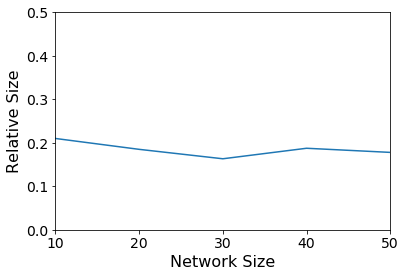

In [17]:
#TODO: graph comparisons
plt.plot(sizes,[yvalue/sizes[i] for i,yvalue in enumerate(yvalues)])
plt.ylabel("Relative Size",fontsize=16)
plt.xlabel("Network Size",fontsize=16)
plt.xticks([10,20,30,40,50],[10,20,30,40,50],fontsize=14)
plt.yticks(fontsize=14) #np.arange(0,1,.1)
plt.xlim(10,50)
plt.ylim([0,0.5])
#plt.legend(fontsize=14)